# Libs and pre-definitions

In [1]:
import os
REPOSITORY_PATH = r'/home/luis-felipe/UncEst'
DATA_PATH = os.path.join(REPOSITORY_PATH,'data')
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = os.path.join(REPOSITORY_PATH,'torch_models')
PATH_TRAINER = os.path.join(PATH_MODELS,'trainer')

### Bibliotecas padrões python e utils pytorch

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from torch import nn

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


### Bibliotecas desenvolvidas

https://github.com/lfpc/Uncertainty_Estimation

In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import torch_data
from uncertainty import metrics

# Classifier

## Definitions

In [5]:
MODEL_ARC = 'ResNet50'#WideResNet ResNet101,ResNet18,ResNet34,ResNet50 CNN8
DATA = 'Cifar100'

In [6]:
TRAIN = False

In [7]:
VAL_SIZE = 0.1

loss_criterion = nn.CrossEntropyLoss()
risk_dict = None#{'selective_risk_mcp':  lambda x,label: unc_comp.selective_risk(x,label,unc_type = unc.MCP_unc)}

data_params = {'train_batch_size': 128, 'validation_size': VAL_SIZE, 'test_batch_size': 100}
NAME = f'{MODEL_ARC}_{DATA}_Val10'

In [8]:
CREATE_DIR = True #If true, creates directories to save model (weights_path)
LIVE_PLOT = True #If True, plot* loss while training. If 'print', print loss per epoch
SAVE_CHECKPOINT = False #If True, save (and update) model weights for the best epoch (smallest validation loss)
SAVE_ALL = False #If True, saves weights and trainer at the end of training

In [9]:
data = torch_data.__dict__[DATA](data_dir = DATA_PATH,validation_as_train = True,params = data_params)
num_classes = data.n_classes
model_class = models.__dict__[MODEL_ARC]

weights_path = os.path.join(PATH_MODELS,MODEL_ARC,DATA)

if CREATE_DIR and not os.path.isdir(weights_path):
    os.makedirs(weights_path)

Files already downloaded and verified
Files already downloaded and verified


## Upload Base Model

In [10]:
if not TRAIN:
    if DATA == 'ImageNet':
        weights = models.pretrained_models[model_class]
        pre_model = model_class(weights = weights).to(dev)
        data.transforms_test = weights.transforms()
    else:
        pre_model = model_class(num_classes = data.n_classes).to(dev)
        pre_model.load_state_dict(utils.upload_weights(weights_path,NAME))

## Train Base Model

In [11]:
N_EPOCHS_0 = 200
if TRAIN:
    loss_criterion = nn.CrossEntropyLoss()
    pre_model = model_class(num_classes = data.n_classes).to(dev)
    optimizer = torch.optim.SGD(pre_model.parameters(), lr =0.1,momentum = 0.9,weight_decay = 5e-4,nesterov = True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS_0)
    model_trainer = TE.Trainer(pre_model,optimizer,loss_criterion, None,data.test_dataloader,lr_scheduler = scheduler)
    model_trainer.fit(data.train_dataloader,N_EPOCHS_0, live_plot = LIVE_PLOT,save_checkpoint = SAVE_CHECKPOINT,PATH = weights_path)

## Inference

In [12]:
pre_model.eval()
acc = TE.model_acc(pre_model,data.train_dataloader)
print('Conjunto de treinamento: acc = ', acc)
acc = TE.model_acc(pre_model,data.validation_dataloader)
print('Conjunto de validação: acc = ', acc)
acc = TE.model_acc(pre_model,data.test_dataloader)
print('Conjunto de teste: acc = ', acc)

Conjunto de treinamento: acc =  99.97333333333333
Conjunto de validação: acc =  77.52
Conjunto de teste: acc =  77.81


# Uncertainty Estimator

## Model Definition

In [13]:
from torch.nn.functional import one_hot
class Uncertainty_Estimator(nn.Module):
    def __init__(self,model) -> None:
        super().__init__()
        self.Unc_Regressor = nn.Sequential(nn.Linear(data.n_classes,200),
                                        nn.ReLU(),
                                        #nn.Dropout(0.3),
                                        nn.Linear(200,100),
                                        nn.ReLU(),
                                        nn.Linear(100,100),
                                        nn.ReLU(),
                                        #nn.Dropout(0.3),
                                        nn.Linear(100,1), #globalpooling-max
                                        nn.Sigmoid())
        self.name = 'Unc_Estimator'
        self.base_model = model
        self.base_model.eval()
        utils.freeze_params(self.base_model)
        self.to(next(model.parameters()).device)
    def train(self,b = True):
        self.Unc_Regressor.train(b)
    def forward(self,x):
        with torch.no_grad():
            logits = self.base_model(x)
            y_pred = TE.predicted_class(logits).view(-1)
            y = one_hot(y_pred,logits.size(-1))
        g = self.Unc_Regressor(logits)
        return y*g
    def unc(self,x):
        return -torch.max(self.forward(x),-1).values

## Model Training

### Definitions

In [14]:
from uncertainty.metrics import acc_coverage

class Acc_Coverage_AUX():
    def __init__(self):
        self.y_pred = 0
        self.labels = 0
    def update(self,model,dataloader):
        self.y_pred, self.labels = TE.accumulate_results(model,dataloader)
    def get(self):
        return self.y_pred,self.labels
aux = Acc_Coverage_AUX()

class Acc_Coverage(nn.Module):
    def __init__(self,coverage,aux):
        super().__init__()
        self.coverage = coverage
        self.aux = aux
    def forward(self,model,dataloader):
        with torch.no_grad():
            if self.coverage <0.15:
                self.aux.update(model,dataloader)
            y_pred,labels = self.aux.get()
            g = torch.max(y_pred,dim=-1).values
            acc = acc_coverage(y_pred,labels,1-g,self.coverage)
            return torch.tensor(acc)

In [15]:
c_list = np.around(np.arange(0.1,1,0.1),1)
risk_dict = {f'Acc_{int(c*100)}':Acc_Coverage(c,aux) for c in c_list}
N_EPOCHS= 2000
optim_params = {'lr':0.001,'weight_decay':5e-4}#{'lr':0.1,'momentum':0.9,'weight_decay':5e-4,'nesterov':True}

### BCE Loss

#### Loss definition

In [16]:
class BCELoss(nn.BCELoss):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    def forward(self,y_pred,y_true):
        with torch.no_grad():
            hits = TE.correct_class(y_pred,y_true).float()
        y_pred = torch.max(y_pred,-1).values
        loss = super().forward(y_pred,hits)
        return loss

loss_criterion = BCELoss()

#### Train

In [17]:
model = Uncertainty_Estimator(pre_model)
model.name = 'Unc_Estimator_BCE'
optimizer = torch.optim.SGD(model.Unc_Regressor.parameters(), **optim_params)
scheduler = None#torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

In [18]:
TE.model_acc(model,data.test_dataloader)

77.81

In [19]:
model_trainer = TE.Trainer(model,optimizer,loss_criterion, data.validation_dataloader,data.test_dataloader,lr_scheduler = scheduler, risk_dict = risk_dict)


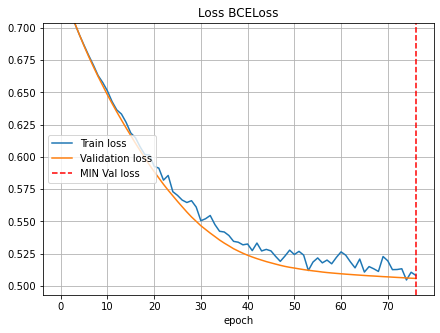

Acc_val (max): 77.81 (77.81) | Loss: 0.5106 | Acc_train: 77.12 |Progress::   4%|3         | 76/2000 [56:50<23:…

In [ ]:
model_trainer.fit(data.validation_dataloader,N_EPOCHS, live_plot = LIVE_PLOT,save_checkpoint = SAVE_CHECKPOINT,PATH = weights_path)

In [ ]:
TE.model_acc(model,data.test_dataloader)

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharey = True,figsize=(16, 6))
for n,risk in model_trainer.hist_train.risk.items():
    c = n[-2:]
    ax1.plot(risk,label = f'{c=}%')
ax1.legend()
ax1.grid()
ax1.set_title('Coverage accuracy - Train (val) set')
ax1.set_ylabel('Error rate')
ax1.set_xlabel('Epoch')
for n,risk in model_trainer.hist_val.risk.items():
    c = n[-2:]
    ax2.plot(risk,label = f'{c=}%')
ax2.legend()
ax2.grid()
ax2.set_title('Coverage accuracy - Test set')
ax2.set_xlabel('Epoch')
plt.subplots_adjust(wspace=0.05)
plt.show()

#### Test

In [ ]:
#Validation (Train2) data
RC = metrics.selective_metrics(pre_model,data.validation_dataloader)
RC.add_uncs({'Trained Activation':model.Unc_Regressor})
RC.d_uncs['Trained Activation'] = -RC.d_uncs['Trained Activation'].view(-1) #Confidence to uncertainty
RC.plot_RC(optimal = True)

In [ ]:
#Test Data
RC = metrics.selective_metrics(pre_model,data.test_dataloader)
RC.add_uncs({'Trained Activation':model.Unc_Regressor})
RC.d_uncs['Trained Activation'] = -RC.d_uncs['Trained Activation'].view(-1) #Confidence to uncertainty
RC.plot_RC(optimal = True)

In [ ]:
class error_loss(nn.Module):
    def __init__(self,reduction = 'mean'):
        super().__init__()
        self.reduction = reduction
    def forward(self,y_pred,y_true):
        error = torch.logical_not(TE.correct_class(y_pred,y_true)).float()
        if self.reduction == 'mean':
            error = torch.mean(error)
        elif self.reduction == 'sum':
            error = torch.sum(error)
        return error

class Selective_Loss(nn.Module):
    def __init__(self, loss_fn = error_loss):
        super().__init__()
        self.loss_fn = loss_fn(reduction = 'none')
    def forward(self,y_pred,y_true):
        with torch.no_grad():
            loss = self.loss_fn(y_pred,y_true)
            g = torch.max(y_pred,-1).values
            loss *= g / torch.sum(g)
        return torch.sum(loss)
loss_sl = Selective_Loss()

class Selective_Net(Selective_Loss):
    def __init__(self,lambd,c, loss_fn = error_loss):
        super().__init__(loss_fn)
        self.lambd = lambd
        self.c = c
    def constraint(self,g):
        r = torch.mean(g)
        return self.lambd*torch.square(torch.nn.functional.relu(self.c-r))
    def forward(self,y_pred,y_true):
        g = torch.max(y_pred,-1).values
        loss = super().forward(y_pred,y_true)
        return loss + self.constraint(g)
loss_criterion = Selective_Net(32,0.4)   

In [ ]:
model = Uncertainty_Estimator(pre_model)
model.name = 'Unc_Estimator_BCE'
optimizer = torch.optim.SGD(model.Unc_Regressor.parameters(), **optim_params)
scheduler = None#torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

In [ ]:
model_trainer = TE.Trainer(model,optimizer,loss_criterion, data.validation_dataloader,data.test_dataloader,lr_scheduler = scheduler, risk_dict = risk_dict)
model_trainer.fit(data.validation_dataloader,N_EPOCHS+100+500+400, live_plot = LIVE_PLOT,save_checkpoint = SAVE_CHECKPOINT,PATH = weights_path)